In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Make sure 'student_exam_scores_12_13.csv' is in the same folder
filename = "student_exam_scores_12_13.csv"

try:
    data = pd.read_csv(filename)
    print("✅ Dataset Loaded Successfully!\n")
    display(data.head())
    
    print("\nMissing Values Before Handling:")
    print(data.isnull().sum())
    
    # Drop rows with any missing values
    data = data.dropna()
    
    print("\nMissing Values After Handling:")
    print(data.isnull().sum())
    
except FileNotFoundError:
    print(f"Error: File '{filename}' not found. Please upload it.")
except Exception as e:
    print(f"An error occurred: {e}")

✅ Dataset Loaded Successfully!



,student_id,hours_studied,sleep_hours,attendance_percent,Internal_marks,exam_score
0,S001,8.0,8.8,72.1,45,30.2
1,S002,1.3,8.6,60.7,55,25.0
2,S003,4.0,8.2,73.7,86,35.8
3,S004,3.5,4.8,95.1,66,34.0
4,S005,9.1,6.4,89.8,71,40.3



Missing Values Before Handling:
student_id            0
hours_studied         0
sleep_hours           0
attendance_percent    0
Internal_marks        0
exam_score            0
dtype: int64

Missing Values After Handling:
student_id            0
hours_studied         0
sleep_hours           0
attendance_percent    0
Internal_marks        0
exam_score            0
dtype: int64


Generating Pairplot for EDA...


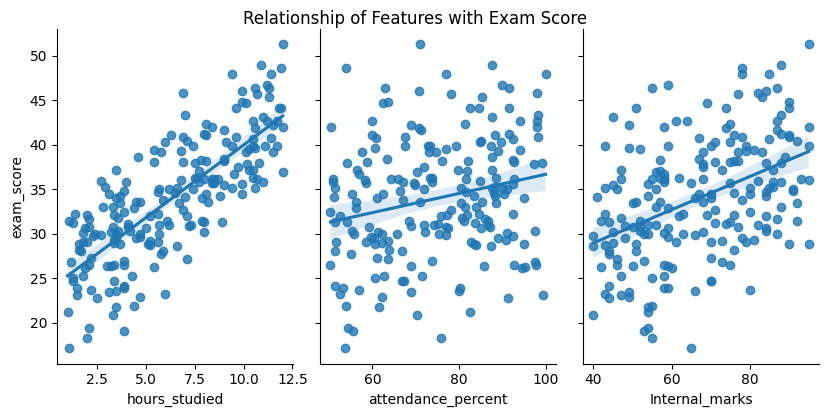

In [3]:
# Use pairplot to visualize relationships between all features and the target
if 'data' in locals():
    print("Generating Pairplot for EDA...")
    sns.pairplot(data, x_vars=['hours_studied', 'attendance_percent', 'Internal_marks'], 
                 y_vars=['exam_score'], height=4, aspect=0.7, kind='reg')
    plt.suptitle('Relationship of Features with Exam Score', y=1.02)
    plt.show()

In [4]:
if 'data' in locals():
    # 1. Define Features (X) and Target (y)
    X = data[['hours_studied', 'attendance_percent', 'Internal_marks']]
    y = data['exam_score']

    # 2. Scale Features
    # Scaling is important for linear models so all features are on a similar scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 3. Simple 80/20 Train-Test Split for a baseline evaluation
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # 4. Train the model on the 80% split
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 5. Evaluate the simple split
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("📊 Linear Regression Evaluation on Simple 80/20 Test Data:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    # Show the learned coefficients
    print("\nModel Coefficients (Weights):")
    print(f"Hours Studied: {model.coef_[0]:.2f}")
    print(f"Attendance:    {model.coef_[1]:.2f}")
    print(f"Internal Marks:  {model.coef_[2]:.2f}")
    print(f"Intercept:       {model.intercept_:.2f}")

📊 Linear Regression Evaluation on Simple 80/20 Test Data:
Mean Squared Error (MSE): 11.05
Root Mean Squared Error (RMSE): 3.32
R² Score: 0.79

Model Coefficients (Weights):
Hours Studied: 5.10
Attendance:    1.60
Internal Marks:  2.55
Intercept:       33.85


In [5]:
if 'X_scaled' in locals():
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    r2_scores = []
    mse_scores = []
    
    print(f"\n🔁 Running K-Fold Cross-Validation (k={k})...")
    
    # kf.split() generates train/test *indices* for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X_scaled)):
        
        # --- This is the part that was missing in your original code ---
        # Get the actual data for this fold using the indices
        X_train_fold = X_scaled[train_index]
        y_train_fold = y.iloc[train_index]
        
        X_test_fold = X_scaled[test_index]
        y_test_fold = y.iloc[test_index]
        # --- End of fix ---
        
        # Train a new model for this specific fold
        model_fold = LinearRegression()
        model_fold.fit(X_train_fold, y_train_fold)
        
        # Evaluate on the fold's test set
        y_pred_fold = model_fold.predict(X_test_fold)
        
        mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
        r2_fold = r2_score(y_test_fold, y_pred_fold)
        
        mse_scores.append(mse_fold)
        r2_scores.append(r2_fold)
        
        print(f"Fold {fold+1}: MSE = {mse_fold:.2f}, R² = {r2_fold:.3f}")

    print("\n📊 Average Cross-Validation Results:")
    print(f"Mean MSE: {np.mean(mse_scores):.2f}")
    print(f"Mean R² Score: {np.mean(r2_scores):.3f}")


🔁 Running K-Fold Cross-Validation (k=5)...
Fold 1: MSE = 11.05, R² = 0.792
Fold 2: MSE = 8.50, R² = 0.810
Fold 3: MSE = 10.41, R² = 0.763
Fold 4: MSE = 8.29, R² = 0.781
Fold 5: MSE = 8.50, R² = 0.825

📊 Average Cross-Validation Results:
Mean MSE: 9.35
Mean R² Score: 0.794


In [6]:
# This cell shows the simple, one-line way to achieve the same as Cell 5
# This is the standard practice.

if 'X_scaled' in locals():
    print("\n🔁 Running K-Fold using sklearn 'cross_val_score' (The Easy Way)...")
    
    model_cv = LinearRegression()
    
    # R-squared
    r2_scores_cv = cross_val_score(model_cv, X_scaled, y, cv=5, scoring='r2')
    
    # Mean Squared Error (Note: sklearn uses 'neg_mean_squared_error')
    mse_scores_cv = -cross_val_score(model_cv, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
    
    print("\n📊 Average Cross-Validation Results (Easy Way):")
    print(f"Mean MSE: {np.mean(mse_scores_cv):.2f}")
    print(f"Mean R² Score: {np.mean(r2_scores_cv):.3f}")


🔁 Running K-Fold using sklearn 'cross_val_score' (The Easy Way)...

📊 Average Cross-Validation Results (Easy Way):
Mean MSE: 9.63
Mean R² Score: 0.788


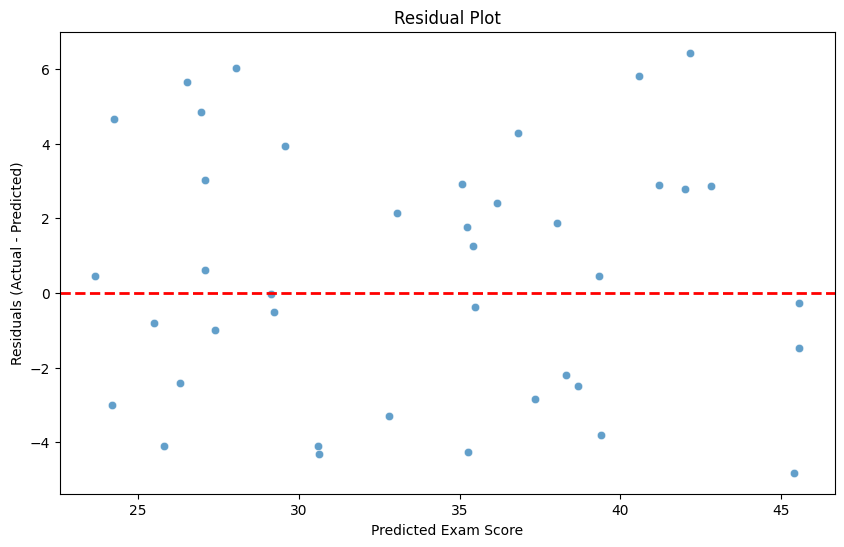

In [7]:
# A residual plot helps check if the model's errors are random
# We use the predictions from our simple train/test split (Cell 4)
if 'y_test' in locals():
    residuals = y_test - y_pred
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--', linewidth=2) # Line at y=0
    plt.title('Residual Plot')
    plt.xlabel('Predicted Exam Score')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.show()